In [4]:
import torch
from pykeen.datasets import get_dataset
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pandas as pd
from sklearn.model_selection import train_test_split
from pykeen import predict
from pykeen.models import MuRE
import os
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm
import json
import torch.optim as optim


#python pytorch python 3.8.19

In [2]:
torch.__version__

'2.3.1+cu118'

In [29]:
file_path = '/home/zhang/hajarlamtaai/KGC/data/data_musee/raw_hrt.tsv'

In [30]:
df = pd.read_csv(file_path, sep='\t')

In [31]:
df.head()

,subject,predicate,object
0,http://wikiba.se/ontology#claim,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#ObjectProperty
1,http://www.w3.org/2004/02/skos/core#altLabel,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#DatatypeProperty
2,http://schema.org/about,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#ObjectProperty
3,http://wikiba.se/ontology#Property,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#Class
4,http://wikiba.se/ontology#statementProperty,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#ObjectProperty


In [32]:
def transductive_split(df, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    assert train_size + val_size + test_size == 1.0

    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    train_count = int(len(df) * train_size)
    val_count = int(len(df) * val_size)
    
    train_entities = set()
    train_relations = set()
    
    train_df = df.head(train_count)
    train_entities.update(train_df['subject'])
    train_entities.update(train_df['object'])
    train_relations.update(train_df['predicate'])
    
    remaining_df = df.iloc[train_count:]
    filtered_remaining_df = remaining_df[
        remaining_df['subject'].isin(train_entities) &
        remaining_df['object'].isin(train_entities) &
        remaining_df['predicate'].isin(train_relations)
    ]
    
    # Splitting the filtered remaining data
    val_df, test_df = train_test_split(
        filtered_remaining_df, 
        test_size=(test_size / (val_size + test_size)), 
        random_state=random_state
    )
    
    return train_df, val_df, test_df

In [33]:
# # train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# # val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# train_df, val_df, test_df= transductive_split(df)

In [34]:
# train_file_path = 'pykeen_data/train.tsv'
# val_file_path = 'pykeen_data/val.tsv'
# test_file_path = 'pykeen_data/test.tsv'

# train_df.to_csv(train_file_path, sep='\t', index=False, header=False)
# val_df.to_csv(val_file_path, sep='\t', index=False, header=False)
# test_df.to_csv(test_file_path, sep='\t', index=False, header=False)

In [35]:

MY_TRAIN_PATH ='pykeen_data/train.tsv'
MY_VAL_PATH ='pykeen_data/val.tsv'
MY_TEST_PATH = 'pykeen_data/test.tsv'


In [36]:
# triples_factory = TriplesFactory.from_path(file_path)
# training, testing, validation = triples_factory.split(
#     ratios=[.95, 0.025, .025],
#     method='coverage'
# )


In [37]:
# print(f"Training set size: {training.num_triples}")
# print(f"Testing set size: {testing.num_triples}")
# print(f"Validation set size: {validation.num_triples}")


In [38]:
# base_save_path = '/content/drive/My Drive/doctests/'
# model_directories = os.listdir(base_save_path)
# print("Available models:", model_directories)

# # for loading

# model_directory = '_'
# load_path = os.path.join(base_save_path, model_directory)
# result = pipeline_result.load_from_directory(load_path)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [72]:
MODEL_NAME= "TransE"
loss_fct = 'pairwisehinge'



Loss fcts : ['Mean Square Error Loss', 'Mean Squared Error Loss', 'Negative Log Likelihood Loss', 'Negative Sampling Self-Adversarial Loss', 'Pairwise Hinge Loss', 'Self-Adversarial Negative Sampling Loss', 'adversarialbcewithlogits', 'bceaftersigmoid', 'bcewithlogits', 'crossentropy', 'doublemargin', 'focal', 'infonce', 'marginranking', 'meansquarederror', 'meansquareerror', 'mse', 'negativeloglikelihood', 'negativesamplingselfadversarial', 'nssa', 'pairwisehinge', 'pairwiselogistic', 'pointwisehinge', 'selfadversarialnegativesampling', 'softmarginranking', 'softplus', 'softpointwisehinge']

In [74]:
checkpoint_path = 'doctests/checkpoint_dir/my_checkpoint.pt'
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

In [78]:
result = pipeline(
    training=MY_TRAIN_PATH,
    validation=MY_VAL_PATH,
    testing=MY_TEST_PATH,

    # dataset_kwargs={'create_inverse_triples': True},
    model=MODEL_NAME, 
    # training_loop='sLCWA',  
    training_kwargs=dict(
        num_epochs=100, 
        use_tqdm_batch=True, 
        checkpoint_name='my_checkpoint.pt',
        checkpoint_directory='doctests/checkpoint_dir',
        checkpoint_frequency=5, 
    ),
    optimizer_kwargs=dict(
        lr=0.0001,
        weight_decay=1e-3     
    ),
    loss=loss_fct,
    # stopper='early',  
    # stopper_kwargs=dict(
    #     patience=10,  
    #     relative_delta=0.001,  
    # ),
    evaluator_kwargs=dict(
        filtered=True,  
    ),
    random_seed=42,
    device = device
   
)


INFO:pykeen.pipeline.api:=> no training loop checkpoint file found at 'doctests/checkpoint_dir/my_checkpoint.pt'. Creating a new file.
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.training.training_loop:=> no checkpoint found at 'doctests/checkpoint_dir/my_checkpoint.pt'. Creating a new file.
Training epochs on cuda:0: 100%|██████████| 100/100 [08:55<00:00,  5.35s/epoch, loss=0.0558, prev_loss=0.0564]
Evaluating on cuda:0: 100%|██████████| 35.0k/35.0k [00:16<00:00, 2.07ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 17.96s seconds


<function matplotlib.pyplot.show(close=None, block=None)>

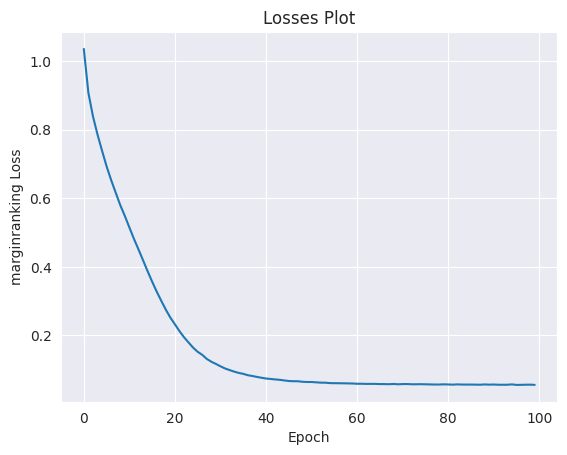

In [79]:
result.plot_losses()
plt.show

In [80]:
metrics_table = result.metric_results.to_df()
print(metrics_table['Metric'].unique())

['z_inverse_harmonic_mean_rank' 'z_arithmetic_mean_rank'
 'adjusted_arithmetic_mean_rank_index' 'count' 'standard_deviation'
 'median_rank' 'harmonic_mean_rank' 'inverse_harmonic_mean_rank'
 'adjusted_arithmetic_mean_rank' 'median_absolute_deviation'
 'z_geometric_mean_rank' 'inverse_geometric_mean_rank'
 'inverse_arithmetic_mean_rank' 'adjusted_inverse_harmonic_mean_rank'
 'adjusted_geometric_mean_rank_index' 'variance' 'inverse_median_rank'
 'geometric_mean_rank' 'arithmetic_mean_rank' 'hits_at_1' 'hits_at_3'
 'hits_at_5' 'hits_at_10' 'z_hits_at_k' 'adjusted_hits_at_k']


In [81]:
realistic_metrics = metrics_table[metrics_table['Rank_type'] == 'optimistic']
key_metrics = realistic_metrics[
    realistic_metrics['Metric'].isin([
        'arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_1', 'hits_at_3', 'hits_at_10'
    ])
]

In [82]:
key_metrics

,Side,Rank_type,Metric,Value
108,head,optimistic,inverse_arithmetic_mean_rank,0.000106
109,tail,optimistic,inverse_arithmetic_mean_rank,0.000266
110,both,optimistic,inverse_arithmetic_mean_rank,0.000151
162,head,optimistic,arithmetic_mean_rank,9457.514705
163,tail,optimistic,arithmetic_mean_rank,3766.331407
164,both,optimistic,arithmetic_mean_rank,6611.923056
171,head,optimistic,hits_at_1,0.026034
172,tail,optimistic,hits_at_1,0.176232
173,both,optimistic,hits_at_1,0.101133
180,head,optimistic,hits_at_3,0.033701


In [83]:
def save_model_results(df, model_name, filename='./pykeen_results/models_metrics'):
    results_dict = df.to_dict(orient='records')
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            existing_data = json.load(f)
    else:
        existing_data = {}
    
    existing_data[model_name] = results_dict
    with open(filename, 'w') as f:
        json.dump(existing_data, f, indent=4)

In [84]:
# save_model_results(key_metrics, MODEL_NAME)

In [85]:
#target prediction example:
from pykeen.predict import predict_target
head_uri = "http://www.wikidata.org/entity/Q118142339"
relation_uri = "http://www.wikidata.org/prop/direct/P31"


pred = predict_target(
    model=result.model,
    head=head_uri,
    relation=relation_uri,
    triples_factory=result.training,
)


In [86]:
# pred_filtered = pred.filter_triples(dataset.training)
# pred_annotated = pred_filtered.add_membership_columns(validation=dataset.validation, testing=dataset.testing)
tails = pred.df
tails.head()
# http://www.wikidata.org/entity/Q182791

,tail_id,score,tail_label
118021,118021,-6.541101,http://www.wikidata.org/entity/Q179700
129815,129815,-7.125266,http://www.wikidata.org/entity/Q3305213
138965,138965,-7.305830,http://www.wikidata.org/entity/Q93184
137216,137216,-7.652369,http://www.wikidata.org/entity/Q860861
111148,111148,-7.790608,http://www.wikidata.org/entity/Q11060274


In [87]:


# torch.save(result.model.state_dict(), f'./pykeen_results/{MODEL_NAME}.pth')